In [1]:
import os
import sys

# For Jupyter notebooks, get the current directory
current_dir = os.getcwd()
print(current_dir)

# Get the directory containing 'EvDemandModel'
parent_dir = os.path.dirname(os.path.dirname(current_dir))
print(parent_dir)

# Appending the parent directory to the Python path
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Geocoding
import geopandas as gpd
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

from EvDemandModel.Preprocessing import Preprocess
from EvDemandModel.Calibration import CalculateCalibrationFactors
from EvDemandModel.Utils import CalibrationFactorApplier
from EvDemandModel.OnPlotParking import CalculateProportionOfVehiclesWithOnPlotParking, CalculateProportionOfEVsWithOnPlotParking
from EvDemandModel.SubstationMapping import LoadDistributionSubstationData, SubstationDataMapper

from importlib import reload

/Users/isaacflower/Library/CloudStorage/OneDrive-UniversityofBath/Documents/PhD/EV Modelling/net-zero-energy-systems/EvDemandModel/Dev
/Users/isaacflower/Library/CloudStorage/OneDrive-UniversityofBath/Documents/PhD/EV Modelling/net-zero-energy-systems


In [2]:
def calculate_opp_proportions(preprocessed_data, quarter):
    opp_props = {}
    opp_props['vehicle'] = CalculateProportionOfVehiclesWithOnPlotParking.calculate(
        preprocessed_data['accommodation_type_2021'],
        preprocessed_data['house_2021'],
        preprocessed_data['car_van_2021'],
    )
    
    for vehicle_type in ['bev', 'phev']:
        opp_props[f'{vehicle_type}'] = CalculateProportionOfEVsWithOnPlotParking.calculate(
            opp_props['vehicle'],
            preprocessed_data[f'vehicle_registrations_i'],
            preprocessed_data[f'{vehicle_type}_registrations_i'],
            quarter
        )
    return opp_props

def apply_calibration_factors(preprocessed_data, calibration_factors, quarter):
    adoptions = {}
    for vehicle_type in ['vehicle', 'bev', 'phev']:
        adoptions[f'{vehicle_type}'] = CalibrationFactorApplier.calibrate(
            preprocessed_data[f'{vehicle_type}_registrations_i'],
            calibration_factors,
            quarter
        )
    return adoptions

In [3]:
preprocessed_data = Preprocess.preprocess()

CarVan2011DataPreprocessor pre-processing complete
CarVan2021DataPreprocessor pre-processing complete
VehicleRegistrationsDataPreprocessor pre-processing complete
EVRegistrationsDataPreprocessor pre-processing complete
EVRegistrationsDataPreprocessor pre-processing complete
HouseDataPreprocessor pre-processing complete
AccommodationTypeDataPreprocessor pre-processing complete
LSOABoundaryDataPreprocessor pre-processing complete
Interpolating Data...
Interpolating Data...
Interpolating Data...


In [4]:
def filter_data_by_lad(data: dict, lad: str) -> dict:
    lad_lsoas = data['car_van_2011'][data['car_van_2011']['LSOA11NM'].str[:-5] == lad].index.values
    result = {}
    for key, df in data.items():
        result[key] = df.loc[lad_lsoas]
    return result

In [5]:
lad = 'Bath and North East Somerset'
lad_preprocessed_data = filter_data_by_lad(preprocessed_data, lad)

In [6]:
calibration_factors = CalculateCalibrationFactors.calculate(
    lad_preprocessed_data['car_van_2011'],
    lad_preprocessed_data['car_van_2021'],
    lad_preprocessed_data['vehicle_registrations']
)

Calculating relative errors...
Generating calibration factor samples...


In [7]:
opp_proportions = calculate_opp_proportions(lad_preprocessed_data, '2023 Q1')

adoptions = apply_calibration_factors(lad_preprocessed_data, calibration_factors, '2023 Q1')

bev_with_opp = adoptions['bev'].mul(opp_proportions['bev']).round(0)
phev_with_opp = adoptions['phev'].mul(opp_proportions['phev']).round(0)

data = {
    'vehicles': adoptions['vehicle'], 
    'bevs': adoptions['bev'],
    'phevs': adoptions['phev'],
    'bevsWithOnPlotParking': bev_with_opp,
    'phevsWithOnPlotParking': phev_with_opp
}

In [8]:
reload(LoadDistributionSubstationData)

ds_data = LoadDistributionSubstationData.load_data()

ds_data = ds_data.set_index('Substation Number', drop=False)

# Drop Duplicates
ds_data = ds_data.loc[~ds_data.index.duplicated(keep='first')]

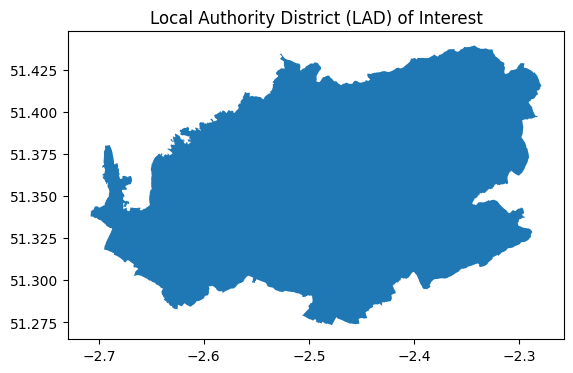

In [9]:
def return_lad_geo(lad):
    return ox.geocoder.geocode_to_gdf(lad, which_result=1)

return_lad_geo(lad).plot()
plt.title('Local Authority District (LAD) of Interest')
plt.show()

In [10]:
def filter_ds_by_lad(ds_data, lad_geo):
    return ds_data.loc[ds_data.Location.within(lad_geo.geometry.values[0])]

lad_geo = return_lad_geo(lad)
ds_lad = filter_ds_by_lad(ds_data, lad_geo)
ds_lad.head()

,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Name,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers,Location
Substation Number,,,,,,,,,,,,,,,,,,,,,
110055,110055,"POLYGON ((-2.46167 51.39973, -2.46174 51.39976...",33528,19,Saltford Od,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Saltford Od,ST682140670940,-2.45840,51.401900,302.0,211.0,500.0,3.0,130.0,POINT (-2.45840 51.40190)
110060,110060,"POLYGON ((-2.49497 51.40702, -2.49581 51.40727...",33532,19,Keelings Ss,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Keelings Ss,ST658270679910,-2.49280,51.409800,140.0,68.0,315.0,3.0,113.0,POINT (-2.49280 51.40980)
110066,110066,"POLYGON ((-2.49769 51.40349, -2.49779 51.40351...",33542,19,Burnett Rd K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Burnett Rd K,ST658460673840,-2.49242,51.404389,117.0,55.0,300.0,3.0,94.0,POINT (-2.49242 51.40439)
110165,110165,"POLYGON ((-2.51360 51.41669, -2.51393 51.41716...",33683,19,Stockwood Vale Od,15049,Keynsham West,128239,Feeder Road 33kv,130,...,Stockwood Vale Od,ST644800689440,-2.51220,51.418300,89.0,44.0,500.0,0.0,47.0,POINT (-2.51220 51.41830)
110182,110182,"POLYGON ((-2.46675 51.40341, -2.46675 51.40341...",33715,19,Grange Road K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,Grange Road K Saltford,ST677120673570,-2.46560,51.404300,79.0,47.0,315.0,4.0,54.0,POINT (-2.46560 51.40430)


In [11]:
len(ds_lad.index.values)

1759

In [12]:
ds_lad['Customers'].isna().sum()

651

In [112]:
from scipy.stats import binom

class OldSubstationDataMapper:
    PERCENTILE_INCREMENT = 5

    def __init__(self, ds_data: pd.DataFrame, lsoa_boundaries: gpd.GeoDataFrame, house_data: pd.DataFrame) -> None:
        self.ds_data = ds_data.set_index('Substation Number')
        self.lsoa_boundaries = lsoa_boundaries
        self.house_data = house_data

    def map_to_substation(self, data: dict) -> dict:
        mapped_data = {key: pd.DataFrame(index=[f"{i}%" for i in range(0, 101, self.PERCENTILE_INCREMENT)], columns=self.ds_data.index.values) for key in data}
        for substation in self.ds_data.index.values:
            parent_lsoas, intersections = self._find_parent_lsoas(substation)
            for key in data:
                mapped_data[key][substation] = self._allocate_data_from_lsoa_to_ds(data[key], substation, parent_lsoas, intersections)
        return mapped_data

    def _find_parent_lsoas(self, substation: str):
        intersections = self.lsoa_boundaries.geometry.intersection(self.ds_data.loc[substation].geometry)
        pip_mask = ~intersections.is_empty
        parent_lsoas = self.lsoa_boundaries[pip_mask].index.values
        return parent_lsoas, intersections
    
    def _allocate_data_from_lsoa_to_ds(self, data: pd.DataFrame, substation: str, parent_lsoas: list, intersections):
        # A list to store the resulting binomial samples for all LSOAs
        total_data_from_lsoas = []

        # Calculating household intersection values once for performance reasons
        household_intersection = self._calculate_household_intersection(substation, parent_lsoas, intersections)

        for lsoa in parent_lsoas:
            # n_values is a series of 1000 elements (samples)
            n_values = np.maximum(data[lsoa].fillna(0).astype(int), 0)
            
            # Probability remains the same across all 1000 samples for this LSOA
            p = np.clip(household_intersection.loc[lsoa], 0, 1)
            
            # Generating binomial samples for this LSOA based on n_values and p
            lsoa_samples = binom.rvs(n=n_values, p=p)
            
            # Appending this LSOA's binomial samples to the list
            total_data_from_lsoas.append(lsoa_samples)

        # Summing over the columns (i.e., summing the binomial samples of each LSOA)
        summed_data_from_lsoas = np.sum(total_data_from_lsoas, axis=0)

        # Calculating percentiles for the resulting summed data
        return self._calculate_percentiles(data=summed_data_from_lsoas)

    def _calculate_household_intersection(self, substation: str, parent_lsoas: list, intersections):
        ds_customers_in_lsoas = self._calculate_ds_customers_based_on_intersection(substation, parent_lsoas, intersections)
        households = self.house_data.loc[parent_lsoas].households
        return ds_customers_in_lsoas.divide(households)

    def _calculate_ds_customers_based_on_intersection(self, substation: str, parent_lsoas: list, intersections):
        intersection_areas = intersections.loc[parent_lsoas].area
        substation_area = self.ds_data.loc[substation].geometry.area
        relative_intersections = intersection_areas / substation_area
        ds_customers_in_lsoas = relative_intersections * self.ds_data.loc[substation, 'Customers']
        return ds_customers_in_lsoas.fillna(0)

    def _calculate_percentiles(self, data):
        percentiles = [np.percentile(data, p).astype(int) for p in range(0, 101, self.PERCENTILE_INCREMENT)]
        percentile_series = pd.Series(percentiles, index=[f"{i}%" for i in range(0, 101, self.PERCENTILE_INCREMENT)])
        return percentile_series

In [113]:
substation_data_mapper = OldSubstationDataMapper(
    ds_data=ds_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

substation_vehicle_data = substation_data_mapper.map_to_substation(data=data)

In [114]:
evs = substation_vehicle_data['bevs'] = substation_vehicle_data['phevs']
evs_with_opp = substation_vehicle_data['bevsWithOnPlotParking'] + substation_vehicle_data['phevsWithOnPlotParking']
evs_with_opp

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5%,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10%,1,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
15%,2,0,0,0,0,0,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
20%,2,1,0,0,0,2,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0
25%,3,1,1,0,0,2,3,3,2,1,...,0,0,0,0,0,0,0,0,0,0
30%,3,1,1,0,0,2,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0
35%,4,1,1,0,0,2,3,3,3,2,...,0,0,0,0,0,0,0,0,0,0
40%,4,1,1,1,1,2,3,3,4,3,...,0,0,0,0,0,0,0,0,0,0
45%,4,2,1,1,1,2,3,4,4,3,...,0,0,0,0,0,0,0,0,0,0


/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_63056/3872375085.py:4: RuntimeWarning: invalid value encountered in cast
  y = np.array(ds_lad['EV Chargers'].values).astype(int)


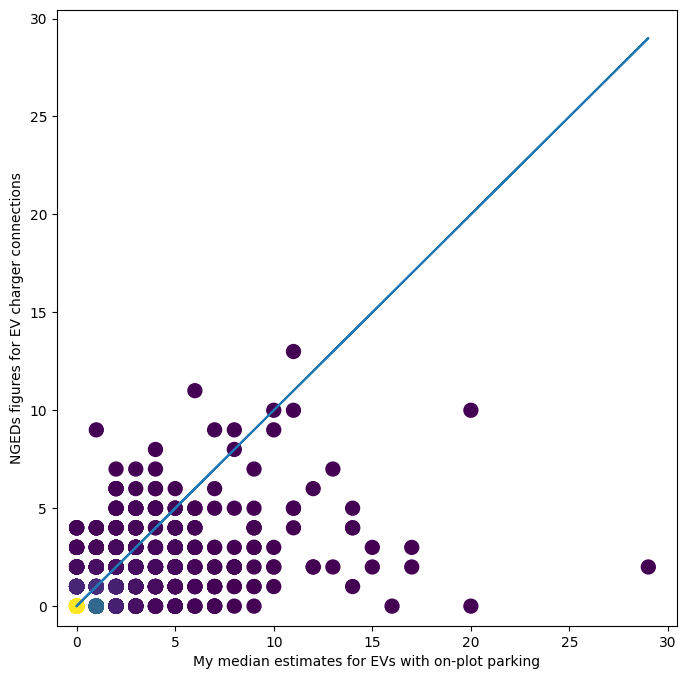

In [115]:
from scipy.stats import gaussian_kde

x = evs_with_opp.loc['50%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My median estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_63056/633552260.py:2: RuntimeWarning: invalid value encountered in cast
  y = np.array(ds_lad['EV Chargers'].values).astype(int)


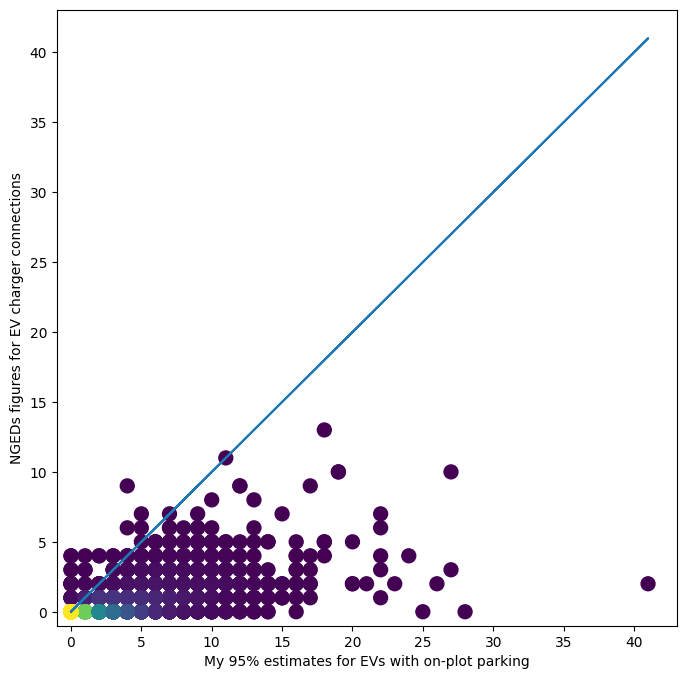

In [116]:
x = evs_with_opp.loc['95%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My 95% estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

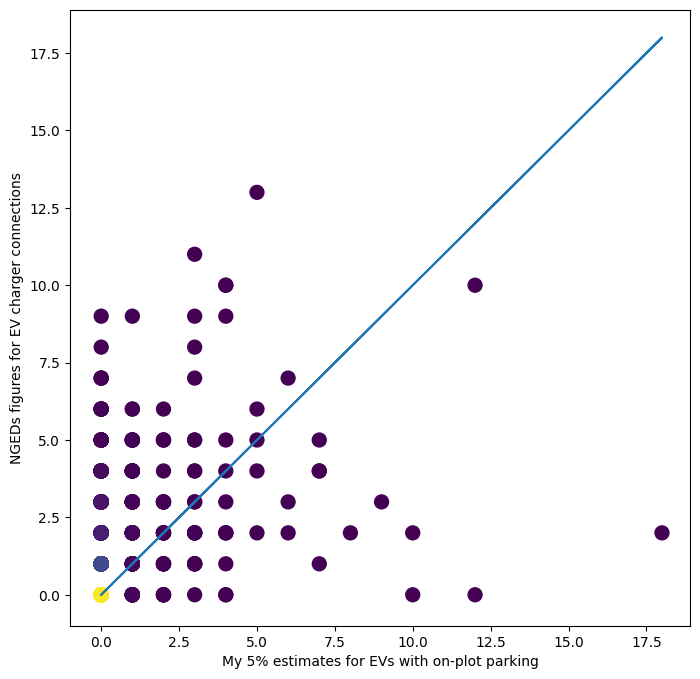

In [583]:
x = evs_with_opp.loc['5%'].values
y = np.array(ds_lad['EV Chargers'].values).astype(int)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, c=z, s=100)
ax.plot(x, x)
ax.set_xlim(left=-1)
ax.set_ylim(bottom=-1)
ax.set_xlabel('My 5% estimates for EVs with on-plot parking')
ax.set_ylabel('NGEDs figures for EV charger connections')
plt.show()

In [104]:
ds_lad['EV Chargers']

Substation Number
110055    3.0
110060    3.0
110066    3.0
110165    0.0
110182    4.0
         ... 
183036    NaN
183052    NaN
183057    NaN
183114    NaN
183123    NaN
Name: EV Chargers, Length: 1759, dtype: float64

In [118]:
evs_with_opp.loc['50%']

110055    5
110060    3
110066    2
110165    1
110182    2
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 50%, Length: 1759, dtype: int64

In [119]:
def evaluate_predctions(lower, upper): # Not a proper function
    evalulation = ((ds_lad['EV Chargers'] >= evs_with_opp.loc[lower]) & (ds_lad['EV Chargers'] <= evs_with_opp.loc[upper]))
    return sum(evalulation)/len(evalulation)

In [120]:
evaluate_predctions('0%', '100%')

0.6202387720295622

In [123]:
evaluate_predctions('5%', '95%')

0.579874928936896

In [124]:
evaluate_predctions('10%', '90%')

0.5537237066515065

In [125]:
evaluate_predctions('25%', '75%')

0.44741330301307564

In [126]:
evaluate_predctions('40%', '60%')

0.33143831722569644

In [127]:
evaluate_predctions('45%', '55%')

0.2905059693007391

# Errors

In [590]:
percentiles = [f"{i}%" for i in range(0, 101, 5)]
errors_df = pd.DataFrame(index=percentiles, columns=ds_lad.index.values)
for percentile in [f"{i}%" for i in range(0, 101, 5)]:
    errors_df.loc[percentile] = (evs_with_opp.loc[percentile] - ds_lad['EV Chargers'])
    
errors_df

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0%,-3,-3,-3,0,-4,-3,-4,-1,-4,-3,...,0,0,0,0,0,0,0,0,0,0
5%,-3,-3,-3,0,-4,-3,-3,-1,-4,-3,...,0,0,0,0,0,0,0,0,0,0
10%,-2,-3,-3,0,-4,-3,-3,0,-3,-2,...,0,0,0,0,0,0,0,0,0,0
15%,-1,-3,-3,0,-4,-3,-2,0,-2,-2,...,0,0,0,0,0,0,0,0,0,0
20%,-1,-2,-3,0,-4,-1,-2,1,-2,-2,...,0,0,0,0,0,0,0,0,0,0
25%,0,-2,-3,0,-4,-1,-1,2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
30%,0,-2,-2,0,-4,-1,-1,2,-2,-1,...,0,0,0,0,0,0,0,0,0,0
35%,0,-2,-2,0,-4,-1,-1,2,-2,-1,...,0,0,0,0,0,0,0,0,0,0
40%,1,-1,-2,1,-3,-1,-1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
45%,1,-1,-2,1,-3,-1,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [591]:
errors_df.mean(axis=1)

0%     -0.700398
5%     -0.503695
10%    -0.374645
15%    -0.261512
20%    -0.146106
25%    -0.039227
30%     0.059125
35%     0.165435
40%     0.280841
45%     0.403638
50%     0.519613
55%     0.659466
60%     0.809551
65%     0.958499
70%     1.125071
75%      1.30415
80%     1.542354
85%     1.827175
90%     2.159181
95%     2.704946
100%    5.370097
dtype: object

In [351]:
errors_df[errors_df==0].replace(0, 1).sum(axis=1)

0%      1193.0
5%      1197.0
10%     1204.0
15%     1198.0
20%     1187.0
25%     1191.0
30%     1186.0
35%     1168.0
40%     1137.0
45%     1110.0
50%     1077.0
55%     1049.0
60%     1016.0
65%      984.0
70%      940.0
75%      907.0
80%      859.0
85%      799.0
90%      758.0
95%      720.0
100%     687.0
dtype: float64

In [592]:
errors_df[errors_df==0].replace(0, 1).sum(axis=1)/len(errors_df.columns.values)

0%      0.676521
5%      0.679932
10%     0.682774
15%     0.679932
20%     0.674247
25%     0.678226
30%     0.673110
35%     0.664582
40%     0.643547
45%     0.627629
50%     0.613985
55%     0.592951
60%     0.574190
65%     0.557135
70%     0.534395
75%     0.512223
80%     0.487777
85%     0.459920
90%     0.429790
95%     0.409892
100%    0.388857
dtype: float64

(0.0, 1.0)

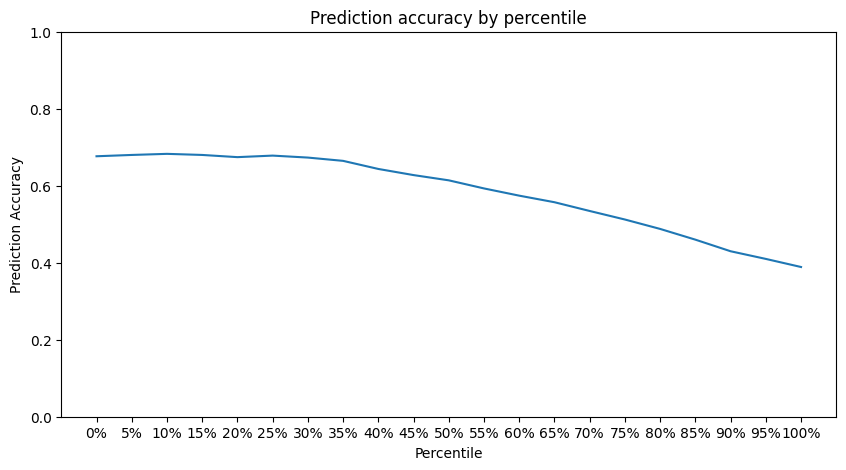

In [593]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(errors_df[errors_df==0].replace(0, 1).sum(axis=1)/len(errors_df.columns.values))
plt.title('Prediction accuracy by percentile')
plt.ylabel('Prediction Accuracy')
plt.xlabel('Percentile')
plt.ylim(0, 1)

In [594]:
(errors_df==0).sum().gt(0).sum()

1662

Proportion of substations in which the NGED EV charger counts were encompased by the full percentile range.

In [595]:
(errors_df==0).sum().gt(0).sum()/len(errors_df.columns.values)

0.9448550312677658

# Ability to predict specific EV charger numbers

In [596]:
evs_with_opp.loc['5%']

110055    0
110060    0
110066    0
110165    0
110182    0
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 5%, Length: 1759, dtype: int64

In [597]:
evs_with_opp.loc['95%']

110055    10
110060     7
110066     5
110165     4
110182     5
          ..
183036     0
183052     0
183057     0
183114     0
183123     0
Name: 95%, Length: 1759, dtype: int64

In [598]:
ds_lad['EV Chargers']

Substation Number
110055    3
110060    3
110066    3
110165    0
110182    4
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: EV Chargers, Length: 1759, dtype: Int64

In [599]:
sum((ds_lad['EV Chargers'] >= evs_with_opp.loc['5%']) & (ds_lad['EV Chargers'] <= evs_with_opp.loc['95%']))

1674

In [600]:
ids = ds_lad[ds_lad['EV Chargers'] == 0].index
ids

Index(['110165', '110391', '110646', '110817', '110818', '110820', '110824',
       '110827', '110828', '110829',
       ...
       '182986', '183015', '183017', '183030', '183032', '183036', '183052',
       '183057', '183114', '183123'],
      dtype='object', name='Substation Number', length=1192)

In [601]:
sum((ds_lad.loc[ids, 'EV Chargers'] >= evs_with_opp.loc['5%', ids]) & (ds_lad.loc[ids, 'EV Chargers'] <= evs_with_opp.loc['95%', ids]))

1168

In [602]:
# Number of predictions that contain the "true" value (between 5% and 95%)
predictions = pd.DataFrame(index=np.arange(0, 20), columns=['n_evs', 'counts', 'accuracy'])
for n in np.arange(0, 20):
    ids = ds_lad[ds_lad['EV Chargers'] == n].index
    counts = sum((ds_lad.loc[ids, 'EV Chargers'] >= evs_with_opp.loc['5%', ids]) & (ds_lad.loc[ids, 'EV Chargers'] <= evs_with_opp.loc['95%', ids]))
    predictions.loc[n, 'n_evs'] = n
    predictions.loc[n, 'counts'] = counts

    if len(ds_lad.loc[ids, 'EV Chargers']) == 0:
        predictions.loc[n, 'accuracy'] = counts/np.nan
    else:
        predictions.loc[n, 'accuracy'] = counts/len(ds_lad.loc[ids, 'EV Chargers'])

predictions

,n_evs,counts,accuracy
0,0,1168,0.979866
1,1,236,0.932806
2,2,112,0.848485
3,3,74,0.91358
4,4,36,0.765957
5,5,27,0.964286
6,6,8,0.8
7,7,4,0.8
8,8,2,1.0
9,9,3,0.75


In [603]:
# Number of predictions that contain the "true" value (between 25% and 75%)
predictions = pd.DataFrame(index=np.arange(0, 20), columns=['n_evs', 'counts', 'accuracy'])
for n in np.arange(0, 20):
    ids = ds_lad[ds_lad['EV Chargers'] == n].index
    counts = sum((ds_lad.loc[ids, 'EV Chargers'] >= evs_with_opp.loc['25%', ids]) & (ds_lad.loc[ids, 'EV Chargers'] <= evs_with_opp.loc['75%', ids]))
    predictions.loc[n, 'n_evs'] = n
    predictions.loc[n, 'counts'] = counts

    if len(ds_lad.loc[ids, 'EV Chargers']) == 0:
        predictions.loc[n, 'accuracy'] = counts/np.nan
    else:
        predictions.loc[n, 'accuracy'] = counts/len(ds_lad.loc[ids, 'EV Chargers'])

predictions

,n_evs,counts,accuracy
0,0,1103,0.925336
1,1,162,0.640316
2,2,73,0.55303
3,3,48,0.592593
4,4,24,0.510638
5,5,17,0.607143
6,6,4,0.4
7,7,1,0.2
8,8,1,0.5
9,9,2,0.5


# MAE

In [604]:
percentiles = [f"{i}%" for i in range(0, 101, 5)]
mae_df = pd.DataFrame(index=percentiles, columns=['MAE'])
for percentile in [f"{i}%" for i in range(0, 101, 5)]:
    mae_df.loc[percentile] = abs(substation_vehicle_data['phevsWithOnPlotParking'].loc[percentile] + 
                                 substation_vehicle_data['bevsWithOnPlotParking'].loc[percentile] - 
                                 ds_lad['EV Chargers']
                                 ).mean()
    
mae_df

,MAE
0%,0.726549
5%,0.676521
10%,0.663445
15%,0.670836
20%,0.686185
25%,0.687322
30%,0.712905
35%,0.752132
40%,0.812962
45%,0.869812


<Axes: >

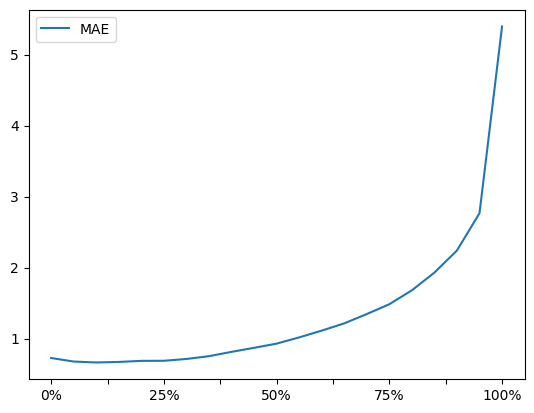

In [605]:
mae_df.plot()

# Low Fidelity Approach

### Primary substation data

In [13]:
ds_lad['PRIM_NRID_NAME'].unique()

array(['Keynsham East', 'Keynsham West', 'Whitchurch', 'Combe Park',
       'Twerton', 'Batheaston', 'Park Street', 'Dorchester St - New',
       'Oldfield Park', 'Entry Hill', 'High Littleton', 'Peasedown',
       'Paulton', 'Foxhills', 'Midsomer Norton', 'Chewton Mendip',
       'Newbury', 'Compton Martin 33/11kv S/S', 'Chew Stoke',
       'Blagdon 33/11kv S/S'], dtype=object)

In [14]:
ds_lad.groupby('PRIM_NRID_NAME')['Customers'].sum()

PRIM_NRID_NAME
Batheaston                    10476.0
Blagdon 33/11kv S/S              32.0
Chew Stoke                     1066.0
Chewton Mendip                 1119.0
Combe Park                     4875.0
Compton Martin 33/11kv S/S     1156.0
Dorchester St - New            8241.0
Entry Hill                     7183.0
Foxhills                       4316.0
High Littleton                 3659.0
Keynsham East                  5524.0
Keynsham West                  4369.0
Midsomer Norton                8115.0
Newbury                           6.0
Oldfield Park                  7491.0
Park Street                    6856.0
Paulton                        2809.0
Peasedown                      3006.0
Twerton                        6088.0
Whitchurch                     1774.0
Name: Customers, dtype: float64

In [15]:
ps = gpd.read_file('../Data/DistributionNetwork/south-west-primary.gpkg').to_crs('EPSG:4326')
ps.head()

,PRIM_NRID_NAME,PRIM_NRID,NR,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,geometry
0,Cheddar,15094,181345,Churchill Bsp 132kv,85,Bridgwater S.G.P.,135,"MULTIPOLYGON (((-2.78699 51.28445, -2.78796 51..."
1,Feeder Road B,15058,113374,Feeder Road 33kv,128239,Iron Acton S.G.P.,130,"MULTIPOLYGON (((-2.55670 51.44990, -2.55654 51..."
2,Foxhills,15078,162344,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.41861 51.30932, -2.41697 51..."
3,Paulton,15072,161315,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49676 51.30564, -2.49676 51..."
4,Wadebridge,15276,437210,St Tudy Bsp,24,Indian Queens S.G.P.,138,"MULTIPOLYGON (((-4.83442 50.51716, -4.83423 50..."


In [16]:
ds_lad.groupby('PRIM_NRID')['Customers'].sum().astype(int)

PRIM_NRID
15042      5524
15047      1774
15049      4369
15061      7491
15062      6856
15064      7183
15065     10476
15066      6088
15067      1119
15068      8115
15072      2809
15074      3659
15076         6
15078      4316
15079      3006
15080      4875
15085        32
15093      1066
15095      1156
302497     8241
Name: Customers, dtype: int64

In [17]:
ps_lad = ps[ps['PRIM_NRID'].isin(ds_lad['PRIM_NRID'].unique())].set_index('PRIM_NRID')
ps_lad['Substation Number'] = ps_lad.index
ps_lad['Customers'] = ds_lad.groupby('PRIM_NRID')['Customers'].sum().astype(int)
ps_lad

,PRIM_NRID_NAME,NR,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,geometry,Substation Number,Customers
PRIM_NRID,,,,,,,,,
15078,Foxhills,162344,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.41861 51.30932, -2.41697 51...",15078,4316
15072,Paulton,161315,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49676 51.30564, -2.49676 51...",15072,2809
15076,Newbury,161701,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.39720 51.27170, -2.39254 51...",15076,6
15066,Twerton,160390,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.40490 51.36898, -2.40574 51...",15066,6088
15064,Entry Hill,160355,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.32577 51.34754, -2.33497 51...",15064,7183
15062,Park Street,160060,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.36149 51.38446, -2.36114 51...",15062,6856
15080,Combe Park,164016,Bath (Dolemeads) 132,94,Melksham S.G.P.,131,"MULTIPOLYGON (((-2.45925 51.41659, -2.45912 51...",15080,4875
15074,High Littleton,161532,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.46296 51.31941, -2.46316 51...",15074,3659
15068,Midsomer Norton,160423,Radstock Bsp 132kv,119,Seabank Sgp,136677,"MULTIPOLYGON (((-2.49827 51.30843, -2.49827 51...",15068,8115


In [689]:
primary_substation_data_mapper = SubstationDataMapper(
    ds_data=ps_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

primary_substation_data = primary_substation_data_mapper.map_to_substation(data=data)

In [690]:
primary_substation_data['bevsWithOnPlotParking']

,15078,15072,15076,15066,15064,15062,15080,15074,15068,15085,15095,15049,15079,15042,15061,15047,302497,15065,15093,15067
0%,18,39,0,37,106,99,42,46,33,0,13,59,26,89,48,40,138,117,23,3
5%,22,46,0,44,115,109,49,55,40,0,20,70,32,99,54,46,146,127,29,7
10%,23,47,0,46,118,112,51,56,41,0,21,72,33,101,56,48,148,129,30,8
15%,24,48,0,47,119,113,52,57,42,0,22,73,34,103,57,49,150,130,31,9
20%,25,49,0,48,121,114,53,58,43,0,23,74,34,104,58,50,151,131,32,9
25%,26,49,0,48,122,116,54,59,44,0,23,75,35,105,59,51,152,132,33,10
30%,26,50,0,49,122,117,55,60,45,0,24,76,35,106,60,52,153,133,34,10
35%,27,51,0,49,124,118,55,60,45,0,24,76,36,107,60,53,154,134,34,11
40%,27,51,0,50,124,119,56,61,46,0,25,77,36,108,61,53,155,135,35,11
45%,28,51,0,50,125,119,56,61,46,0,25,78,36,108,62,54,156,135,35,12


In [691]:
primary_substation_data['bevs'].loc['50%'].sum()

1359

In [611]:
substation_vehicle_data['bevs']

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5%,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10%,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15%,1,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
20%,2,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
25%,2,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30%,2,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
35%,2,0,0,0,0,1,1,1,2,1,...,0,0,0,0,0,0,0,0,0,0
40%,2,1,0,0,1,1,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0
45%,3,1,0,0,1,1,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0


In [612]:
substation_vehicle_data['bevs'].loc['50%'].sum()

898

In [613]:
ps_lad['Customers'].sum()

88161

In [614]:
ds_lad['Customers'].sum()

88161.0

In [615]:
ds_lad.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1759 entries, 110055 to 183123
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Substation Number         1759 non-null   object  
 1   geometry                  1759 non-null   geometry
 2   NRID                      1759 non-null   int64   
 3   NR_TYPE_ID                1759 non-null   int64   
 4   NAME                      1728 non-null   object  
 5   PRIM_NRID                 1759 non-null   int64   
 6   PRIM_NRID_NAME            1759 non-null   object  
 7   BSP_NRID                  1759 non-null   int64   
 8   BSP_NRID_NAME             1759 non-null   object  
 9   GSP_NRID                  1759 non-null   int64   
 10  GSP_NRID_NAME             1759 non-null   object  
 11  index                     1759 non-null   float64 
 12  Licence Area              1759 non-null   object  
 13  Grid Supply Point Number  1759 non-nul

In [616]:
ds_lad['PRIM_NRID'].unique()

array([ 15042,  15049,  15047,  15080,  15066,  15065,  15062, 302497,
        15061,  15064,  15074,  15079,  15072,  15078,  15068,  15067,
        15076,  15095,  15093,  15085])

In [397]:
ds_lad[ds_lad['PRIM_NRID'] == ds_lad['PRIM_NRID'].unique()[0]].index.values

array(['110055', '110060', '110066', '110182', '110215', '110234',
       '110258', '110391', '110434', '110506', '110507', '110646',
       '110651', '110696', '110820', '110821', '110822', '110823',
       '110824', '110827', '110828', '110829', '110974', '111028',
       '111057', '111116', '111141', '111166', '111170', '111233',
       '111234', '111237', '111286', '111378', '111381', '111382',
       '111407', '111408', '111418', '111459', '111488', '111512',
       '111563', '111565', '111589', '111595', '111613', '111658',
       '111738', '111772', '111873', '111874', '111910', '111911',
       '111997', '112106', '112211', '112259', '112328', '112331',
       '112348', '112394', '112396', '112409', '112548', '112596',
       '112629', '112767', '112784', '112811', '112824', '112831',
       '112869', '112876', '112884', '112960', '113003', '113015',
       '113063', '113066', '113133', '113175', '113213', '113243',
       '113322', '113335', '113342', '113365', '113402', '1134

In [617]:
df = pd.DataFrame(index=ds_lad['PRIM_NRID'].unique(), columns=['DS Sum', 'Primary'])
for primary in ds_lad['PRIM_NRID'].unique():
    df.loc[primary, 'DS Sum'] = substation_vehicle_data['bevs'][ds_lad[ds_lad['PRIM_NRID'] == primary].index.values].loc['50%'].sum()
    df.loc[primary, 'Primary'] = primary_substation_data['bevs'].loc['50%', primary]

df

,DS Sum,Primary
15042,99,118
15049,28,86
15047,21,60
15080,61,62
15066,25,55
15065,143,147
15062,95,131
302497,80,170
15061,42,67
15064,121,137


In [618]:
mapped_data.quantile(0.5)

110055    2.0
110060    2.0
110066    1.0
110165    1.0
110182    1.0
         ... 
183036    0.0
183052    0.0
183057    0.0
183114    0.0
183123    0.0
Name: 0.5, Length: 1759, dtype: float64

In [619]:
df = pd.DataFrame(index=ds_lad['PRIM_NRID'].unique(), columns=['DS Sum', 'Primary'])
for primary in ds_lad['PRIM_NRID'].unique():
    df.loc[primary, 'DS Sum'] = mapped_data.quantile(0.5)[ds_lad[ds_lad['PRIM_NRID'] == primary].index.values].sum()
    df.loc[primary, 'Primary'] = primary_substation_data['bevs'].loc['50%', primary]

df

,DS Sum,Primary
15042,102.0,118
15049,88.0,86
15047,38.0,60
15080,63.0,62
15066,25.0,55
15065,191.5,147
15062,102.0,131
302497,85.0,170
15061,54.0,67
15064,159.5,137


In [620]:
df.sum()

DS Sum     1259.5
Primary      1359
dtype: object

# Public Chargers

In [226]:
import polyline
from requests import get

In [173]:
target_ds = ds_lad.sort_values(by='EV Chargers', ascending=False).head(100).index.values[9]
target_ds

'160159'

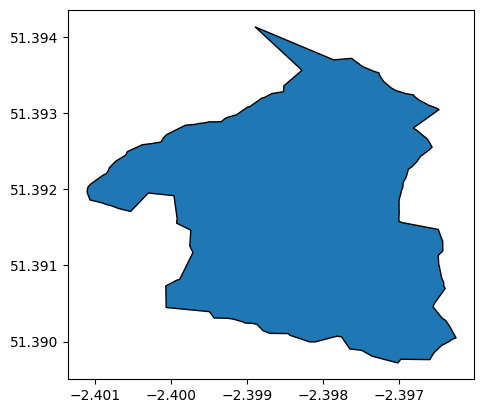

In [175]:
geometry = ds_data.loc[target_ds, 'geometry']

# Plot
fig, ax = plt.subplots()
gpd.GeoSeries([geometry]).plot(ax=ax, edgecolor='k')
plt.show()

# Encode polygons as polylines

In [240]:
def encode_geometry(geometry):
    # Check if the geometry is a Polygon
    if geometry.geom_type == 'Polygon':
        coordinates = list(geometry.exterior.coords)
    # Check if the geometry is a MultiPolygon
    elif geometry.geom_type == 'MultiPolygon':
        # Iterate over each Polygon to find the one with the largest area
        largest_polygon = max(geometry.geoms, key=lambda p: p.area)
        coordinates = list(largest_polygon.exterior.coords)
    else:
        raise TypeError("Geometry must be a Polygon or MultiPolygon")

    # Reverse the coordinates to (lat, lon) for polyline encoding
    coordinates = [(lat, lon) for lon, lat in coordinates]

    # Encode the coordinates to a polyline
    return polyline.encode(coordinates)

def encode_geometry_column(gdf):
    # Apply the encoding function to each geometry
    gdf['encoded_polyline'] = gdf['geometry'].apply(encode_geometry)
    return gdf

In [244]:
ds_lad_encoded = encode_geometry_column(ds_lad)
ds_lad_encoded.head()

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Substation Number,geometry,NRID,NR_TYPE_ID,NAME,PRIM_NRID,PRIM_NRID_NAME,BSP_NRID,BSP_NRID_NAME,GSP_NRID,...,Grid Reference,LONGITUDE,LATITUDE,Day Max Demand,Night Max Demand,Substation Rating,EV Chargers,Customers,Location,encoded_polyline
Substation Number,,,,,,,,,,,,,,,,,,,,,
110055,110055,"POLYGON ((-2.46167 51.39973, -2.46174 51.39976...",33528,19,Saltford Od,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,ST682140670940,-2.45840,51.401900,339.0,228.0,500.0,2,129.0,POINT (-2.45840 51.40190),i_vxHlx_NELe@Va@@A?CEw@sBEQiB_@Ai@AG@i@CK_A\??...
110060,110060,"POLYGON ((-2.49497 51.40702, -2.49581 51.40727...",33532,19,Keelings Ss,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,ST658270679910,-2.49280,51.409800,204.0,90.0,315.0,3,114.0,POINT (-2.49280 51.40980),{lwxHphfNq@fDKF_Ah@iA`@_@?iAyEMSUCmAmAy@kAA?@m...
110066,110066,"POLYGON ((-2.49769 51.40349, -2.49779 51.40351...",33542,19,Burnett Rd K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,ST658460673840,-2.49242,51.404389,157.0,70.0,300.0,3,95.0,POINT (-2.49242 51.40439),yvvxHpyfNCRAAcGt@qAGmAKmB{@ECMKCCEEU]m@aAKUIYm...
110165,110165,"POLYGON ((-2.51360 51.41669, -2.51393 51.41716...",33683,19,Stockwood Vale Od,15049,Keynsham West,128239,Feeder Road 33kv,130,...,ST644800689440,-2.51220,51.418300,102.0,49.0,500.0,0,47.0,POINT (-2.51220 51.41830),iiyxH~|iN}A`AwA`AyCxAEJiAyCRoAQ{@uBlAaAvCGJ}@M...
110182,110182,"POLYGON ((-2.46675 51.40341, -2.46675 51.40341...",33715,19,Grange Road K,15042,Keynsham East,119,Radstock Bsp 132kv,136677,...,ST677120673570,-2.46560,51.404300,104.0,50.0,315.0,4,54.0,POINT (-2.46560 51.40430),ivvxHdx`N????@BFJJT?DHPDNBFu@~AOQkDlG]v@y@}DUi...


In [224]:
column_names = [
    'ID', 
    'Title', 
    'Town',
    'Operator', 
    'Operational', 
    'Connection_Type', 
    'Number_of_Points', 
    'Current_Type', 
    'Power_KW', 
    'Usage',
    'Cost',
    'Latitude', 
    'Longitude'
]

def json_to_dataframe(json_data, column_names):
    
    df = pd.DataFrame(columns = column_names)

    for i in range(len(json_data)):
        if len(json_data[i]['Connections']) > 1:
            for j in range(len(json_data[i]['Connections'])):
                try:
                    mapper = {
                        'ID': str(json_data[i]['AddressInfo']['ID']),
                        'Title': str(json_data[i]['AddressInfo']['Title']),
                        'Town': str(json_data[i]['AddressInfo']['Town']),
                        'Operator': json_data[i]['OperatorInfo']['Title'],
                        'Operational': json_data[i]['Connections'][j]['StatusType']['IsOperational'],
                        'Connection_Type': json_data[i]['Connections'][j]['ConnectionType']['Title'],
                        'Number_of_Points': json_data[i]['Connections'][j]['Quantity'],
                        'Current_Type': json_data[i]['Connections'][j]['CurrentType']['Title'],
                        'Power_KW': json_data[i]['Connections'][j]['PowerKW'],
                        'Usage': json_data[i]['UsageType']['Title'],
                        'Cost': json_data[i]['UsageCost'],
                        'Latitude': json_data[i]['AddressInfo']['Latitude'],
                        'Longitude': json_data[i]['AddressInfo']['Longitude'],
                        }
                    s = pd.Series(mapper)
                    df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
                except:
                    pass
        else:
            try:
                mapper = {
                    'ID': str(json_data[i]['AddressInfo']['ID']),
                    'Title': str(json_data[i]['AddressInfo']['Title']),
                    'Town': str(json_data[i]['AddressInfo']['Town']),
                    'Operator': json_data[i]['OperatorInfo']['Title'],
                    'Operational': json_data[i]['Connections'][0]['StatusType']['IsOperational'],
                    'Connection_Type': json_data[i]['Connections'][0]['ConnectionType']['Title'],
                    'Number_of_Points': json_data[i]['NumberOfPoints'],
                    'Current_Type': json_data[i]['Connections'][0]['CurrentType']['Title'],
                    'Power_KW': json_data[i]['Connections'][0]['PowerKW'],
                    'Usage': json_data[i]['UsageType']['Title'],
                    'Cost': json_data[i]['UsageCost'],
                    'Latitude': json_data[i]['AddressInfo']['Latitude'],
                    'Longitude': json_data[i]['AddressInfo']['Longitude']
                }
                s = pd.Series(mapper)
                df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
            except:
                pass
    return df

# Count Public Chargers For Distribution Substations

In [263]:
import requests
from requests.exceptions import HTTPError, RequestException

def retrieve_ocm_data(polygon):
    max_results = 100
    min_power_kw = 0

    endpoint = ('https://api.openchargemap.io/v3/poi/') # Using the OpenChargeMap API

    parameters = {
        'countrycode':'GB',
        'distanceunit': 'KM',
        'minpowerkw': min_power_kw,
        'maxresults': max_results,
        'polygon': polygon,
        'key': 'b7c88c66-3a61-401e-8b9e-437f66554a9d' # My unique API Key
    }

    response = get(endpoint, params = parameters)
    
    try:
        response = requests.get(endpoint, params=parameters)
        # Check if the request was successful
        response.raise_for_status()
        # If the response was successful, no Exception will be raised
        return response.json()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')  # HTTP error response
    except RequestException as err:
        print(f'Request error occurred: {err}')  # Network-related error occurred
    except Exception as err:
        print(f'Other error occurred: {err}')  # Other error
    return None  # Return None or appropriate error information

In [250]:
ids = ds_lad.index.values

column_names = [
    'ID', 
    'Title', 
    'Town',
    'Operator', 
    'Operational', 
    'Connection_Type', 
    'Number_of_Points', 
    'Current_Type', 
    'Power_KW', 
    'Usage',
    'Cost',
    'Latitude', 
    'Longitude'
]

public_chargers = pd.Series(index=ids)

for id in ids[:5]:
    polygon = ds_lad_encoded.loc[target_ds].encoded_polyline

    json_data = retrieve_ocm_data(polygon)
    
    local_chargers_df = json_to_dataframe(json_data, column_names)
    
    local_chargers_gdf = gpd.GeoDataFrame(
        local_chargers_df, 
        geometry=gpd.points_from_xy(local_chargers_df.Longitude, local_chargers_df.Latitude), 
        crs="EPSG:4326"
    )

    filtered_chargers = local_chargers_gdf[local_chargers_gdf.geometry.within(geometry)]

    public_chargers.loc[id] = len(filtered_chargers)

In [253]:
lad_geo.geometry

0    POLYGON ((-2.70789 51.33781, -2.70764 51.33782...
Name: geometry, dtype: geometry

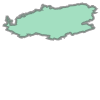

In [258]:
lad_geo.iloc[0].geometry

In [264]:
encode_geometry(lad_geo.iloc[0].geometry)

'i|ixHh{oOAq@E_@@WFSTMHG?O?MAQG_@EQSg@Xe@Aq@Gq@TiATu@n@mALg@Lw@LSHYHC?k@CECULOTa@HYBUA[?QHc@CQo@mBGU?G?EF]NIN?DAJI`@CFG?[ES?SHQJKPEBETyAJ[b@eAHMPGL@DAJMGe@?UBWJm@ASGMYi@AE?GDWJWRYTODEBUKy@CU?SJQb@MP@LEN{@HMJG`@iAh@aAZe@J]H_@DKV]FKT}@HOV_@DIR{@b@w@DYVo@Ve@Zq@`@g@b@w@LKb@YZc@`@WDCFSDm@L[DOFa@DIFIHQVoADSNa@B]P}@bAcCLi@AO@QPc@Nc@R_AEWIU@g@Gm@X]D]?YFe@HK\\EHEL[Pm@d@ZxAt@b@^lAdA~Ap@vCdB|AdAhAt@jAv@xBjBpBrAl@n@j@\\\\ThBtAz@f@l@l@`@Tt@^bBfAhA~@\\f@vA|@X?FWFINALF`@d@\\N`@XxAt@f@`@bBhAd@JTKfBN~@FZHJPNr@dAk@NEDA@kCJqBN_B\\qCLs@NiBLy@CMJu@f@qB\\o@Vi@Hm@@S?g@F_A@i@?c@HIBCH]TuA\\mCRy@NGNKN]XaB?y@Gy@?[BUNKDCFErAr@\\Vn@ZfBqKKG`AeE`@_B\\_Br@}BjA_ExByGp@cBTs@nBkEv@eCL?NLb@DXGTKjBgKu@u@U]}DuENyABe@@yAB_@\\{AVuA^oAFKHKFTn@eBt@sAd@kAJg@J_AV_AX_ALq@~@}Ar@aA`@y@JMNB`Ab@V`@LHpANX?REP[^eAZqAHWD[Ac@IqAIk@@g@Dg@d@yBZcCPm@J]T_@hAkA|@zBz@bBv@dC`@b@NZJ\\@ZxCnBjAb@hAl@TP\\JNBXi@b@l@r@nAj@h@b@TLDIeAEaACk@Cg@SsBMkBUgCEu@Go@GgA?[NqBBo@P}CNkBDq@D}@De@^cBtByJXeBrAiGDQl@oCP_A@GLm@\\aBLi@^e@f@kAZ{@Ti@VUHKNe@Hq@Jy@BM@m@IiB?

In [265]:
retrieve_ocm_data(encode_geometry(lad_geo.iloc[0].geometry))

HTTP error occurred: 520 Server Error:  for url: https://api.openchargemap.io/v3/poi/?countrycode=GB&distanceunit=KM&minpowerkw=0&maxresults=100&polygon=i%7CixHh%7BoOAq%40E_%40%40WFSTMHG%3FO%3FMAQG_%40EQSg%40Xe%40Aq%40Gq%40TiATu%40n%40mALg%40Lw%40LSHYHC%3Fk%40CECULOTa%40HYBUA%5B%3FQHc%40CQo%40mBGU%3FG%3FEF%5DNIN%3FDAJI%60%40CFG%3F%5BES%3FSHQJKPEBETyAJ%5Bb%40eAHMPGL%40DAJMGe%40%3FUBWJm%40ASGMYi%40AE%3FGDWJWRYTODEBUKy%40CU%3FSJQb%40MP%40LEN%7B%40HMJG%60%40iAh%40aAZe%40J%5DH_%40DKV%5DFKT%7D%40HOV_%40DIR%7B%40b%40w%40DYVo%40Ve%40Zq%40%60%40g%40b%40w%40LKb%40YZc%40%60%40WDCFSDm%40L%5BDOFa%40DIFIHQVoADSNa%40B%5DP%7D%40bAcCLi%40AO%40QPc%40Nc%40R_AEWIU%40g%40Gm%40X%5DD%5D%3FYFe%40HK%5CEHEL%5BPm%40d%40ZxAt%40b%40%5ElAdA~Ap%40vCdB%7CAdAhAt%40jAv%40xBjBpBrAl%40n%40j%40%5C%5CThBtAz%40f%40l%40l%40%60%40Tt%40%5EbBfAhA~%40%5Cf%40vA%7C%40X%3FFWFINALF%60%40d%40%5CN%60%40XxAt%40f%40%60%40bBhAd%40JTKfBN~%40FZHJPNr%40dAk%40NEDA%40kCJqBN_B%5CqCLs%40NiBLy%40CMJu%40f%40qB%5Co%40Vi%40Hm%40%40S%3Fg%40F_A%40i%4

# Revised Substation Mapping

In [18]:
revised_substation_data_mapper = SubstationDataMapper(
    ds_data=ds_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

revised_substation_vehicle_data = revised_substation_data_mapper.map_to_substation(data=data)

In [20]:
revised_substation_vehicle_data['bevs'].loc[0.5].sum()

1265

In [88]:
evs_hf_estimates = revised_substation_vehicle_data['bevs'] + revised_substation_vehicle_data['phevs']
evs_with_opp_hf_estimates = revised_substation_vehicle_data['bevsWithOnPlotParking'] + revised_substation_vehicle_data['phevsWithOnPlotParking']
evs_with_opp_hf_estimates

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
Quantile,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,1,0,0,0,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,0,0
0.15,2,0,0,0,0,0,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
0.20,2,0,0,0,0,1,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
0.25,3,1,0,0,0,2,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0
0.30,3,1,1,0,0,2,3,3,2,3,...,0,0,0,0,0,0,0,0,0,0
0.35,3,1,1,1,0,2,3,4,2,3,...,0,0,0,0,0,0,0,0,0,0
0.40,4,1,1,1,1,2,3,5,3,3,...,0,0,0,0,0,0,0,0,0,0


In [67]:
evs_with_opp_hf_estimates.loc[0.5]

110055    4
110060    2
110066    1
110165    1
110182    1
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 0.5, Length: 1759, dtype: int64

In [21]:
primary_substation_data_mapper = SubstationDataMapper(
    ds_data=ps_lad,
    lsoa_boundaries=lad_preprocessed_data['lsoa_boundaries'],
    house_data=lad_preprocessed_data['house_2021']
)

primary_substation_data = primary_substation_data_mapper.map_to_substation(data=data)

In [63]:
low_fidelity_estimate_bevs = pd.DataFrame(index=np.arange(0, 1.01, 0.05), columns=ds_lad.index.values)
low_fidelity_estimate_phevs = pd.DataFrame(index=np.arange(0, 1.01, 0.05), columns=ds_lad.index.values)
low_fidelity_estimate_bevsWithOnPlotParking = pd.DataFrame(index=np.arange(0, 1.01, 0.05), columns=ds_lad.index.values)
low_fidelity_estimate_phevsWithOnPlotParking = pd.DataFrame(index=np.arange(0, 1.01, 0.05), columns=ds_lad.index.values)
for ps in ps_lad.index.values:
    prop = ds_lad[ds_lad['PRIM_NRID'] == ps]['Customers']/ps_lad.loc[ps, 'Customers']
    for ds in ds_lad[ds_lad['PRIM_NRID'] == ps].index.values:
        low_fidelity_estimate_bevs[ds] = round(prop.loc[ds] * primary_substation_data['bevs'][ps]).fillna(0).astype(int)
        low_fidelity_estimate_phevs[ds] = round(prop.loc[ds] * primary_substation_data['phevs'][ps]).fillna(0).astype(int)
        low_fidelity_estimate_bevsWithOnPlotParking [ds] = round(prop.loc[ds] * primary_substation_data['bevsWithOnPlotParking'][ps]).fillna(0).astype(int)
        low_fidelity_estimate_phevsWithOnPlotParking[ds] = round(prop.loc[ds] * primary_substation_data['bevsWithOnPlotParking'][ps]).fillna(0).astype(int)

low_fidelity_estimates = {
    'bevs': low_fidelity_estimate_bevs,
    'phevs': low_fidelity_estimate_phevs,
    'bevsWithOnPlotParking': low_fidelity_estimate_bevsWithOnPlotParking,
    'phevsWithOnPlotParking': low_fidelity_estimate_phevsWithOnPlotParking
}

In [65]:
evs_lf_estimates = low_fidelity_estimates['bevs'] + low_fidelity_estimates['phevs']
evs_with_opp_lf_estimates = low_fidelity_estimates['bevsWithOnPlotParking'] + low_fidelity_estimates['phevsWithOnPlotParking']
evs_with_opp_lf_estimates

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0.00,4,4,4,2,2,2,6,6,4,6,...,0,0,0,0,0,0,0,0,0,0
0.05,6,4,4,2,2,2,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.10,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.15,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.20,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.25,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.30,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.35,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.40,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0
0.45,6,4,4,2,2,4,6,8,4,8,...,0,0,0,0,0,0,0,0,0,0


In [66]:
evs_with_opp_lf_estimates.loc[0.5]

110055    6
110060    4
110066    4
110165    2
110182    2
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 0.5, Length: 1759, dtype: int64

In [68]:
evs_with_opp_hf_estimates.loc[0.5]

110055    4
110060    2
110066    1
110165    1
110182    1
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 0.5, Length: 1759, dtype: int64

In [60]:
ds_lad['EV Chargers'].fillna(0).astype(int)

Substation Number
110055    3
110060    3
110066    3
110165    0
110182    4
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: EV Chargers, Length: 1759, dtype: int64

In [74]:
quantiles = np.arange(0, 1.01, 0.05)
lf_mae_df = pd.DataFrame(index=quantiles, columns=['MAE'])
for quantile in np.arange(0, 1.01, 0.05):
    lf_mae_df.loc[quantile] = abs(evs_with_opp_lf_estimates.loc[quantile] - ds_lad['EV Chargers']).mean()
lf_mae_df

,MAE
0.00,1.455776
0.05,1.601986
0.10,1.641697
0.15,1.670578
0.20,1.683213
0.25,1.699458
0.30,1.722924
0.35,1.74278
0.40,1.748195
0.45,1.768051


<Axes: >

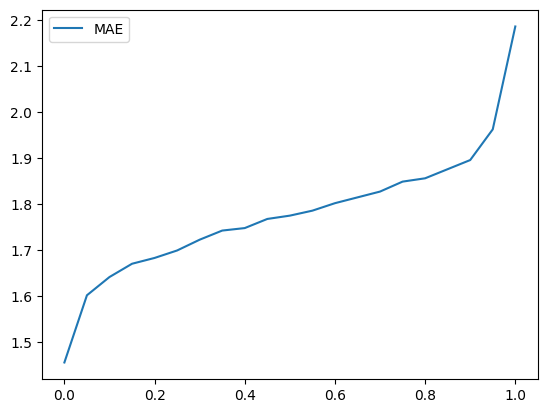

In [75]:
lf_mae_df.plot()

In [76]:
quantiles = np.arange(0, 1.01, 0.05)
hf_mae_df = pd.DataFrame(index=quantiles, columns=['MAE'])
for quantile in np.arange(0, 1.01, 0.05):
    hf_mae_df.loc[quantile] = abs(evs_with_opp_hf_estimates.loc[quantile] - ds_lad['EV Chargers']).mean()
hf_mae_df

,MAE
0.00,1.152527
0.05,1.074007
0.10,1.037004
0.15,1.020758
0.20,1.009025
0.25,0.98556
0.30,1.006318
0.35,1.050542
0.40,1.094765
0.45,1.130866


In [78]:
hf_mae_df.loc[0.5]

MAE    1.207581
Name: 0.5, dtype: object

In [79]:
lf_mae_df.loc[0.5]

MAE    1.775271
Name: 0.5, dtype: object

<Axes: >

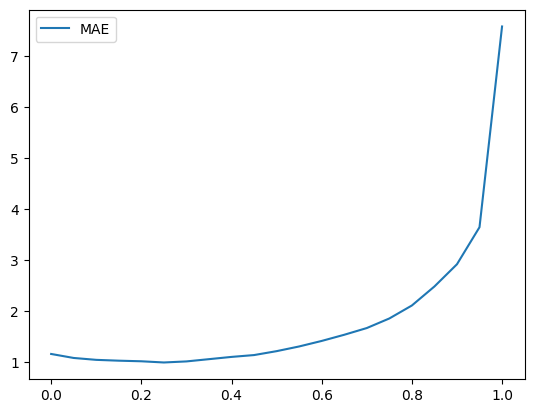

In [77]:
hf_mae_df.plot()

In [82]:
evs_with_opp_hf_estimates

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
Quantile,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
0.10,1,0,0,0,0,0,1,2,0,1,...,0,0,0,0,0,0,0,0,0,0
0.15,2,0,0,0,0,0,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
0.20,2,0,0,0,0,1,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
0.25,3,1,0,0,0,2,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0
0.30,3,1,1,0,0,2,3,3,2,3,...,0,0,0,0,0,0,0,0,0,0
0.35,3,1,1,1,0,2,3,4,2,3,...,0,0,0,0,0,0,0,0,0,0
0.40,4,1,1,1,1,2,3,5,3,3,...,0,0,0,0,0,0,0,0,0,0


In [101]:
evs_with_opp_hf_estimates.iloc[-2]

110055    9
110060    6
110066    5
110165    4
110182    5
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 0.9500000000000001, Length: 1759, dtype: int64

In [102]:
evalulation = ((ds_lad['EV Chargers'] >= evs_with_opp_hf_estimates.loc[0.05]) & (ds_lad['EV Chargers'] <= evs_with_opp_hf_estimates.iloc[-2]))
sum(evalulation)/len(evalulation)

0.5912450255827174

In [103]:
evalulation = ((ds_lad['EV Chargers'] >= evs_with_opp_lf_estimates.loc[0.05]) & (ds_lad['EV Chargers'] <= evs_with_opp_lf_estimates.iloc[-2]))
sum(evalulation)/len(evalulation)

0.25014212620807275

# Experimentation

In [504]:
def find_child_ds(lsoa):
    intersections = ds_lad.geometry.intersection(lad_preprocessed_data['lsoa_boundaries'].loc[lsoa].geometry)
    pip_mask = ~intersections.is_empty
    child_ds = ds_lad[pip_mask].index.values
    return child_ds, intersections

In [678]:
mapped_data = pd.DataFrame(index=range(0, 1000), columns=ds_lad.index.values, data=0)

lad_lsoas = lad_preprocessed_data['house_2021'].index.values

for lsoa in lad_lsoas:
    child_ds, intersections = find_child_ds(lsoa)
    intersection_areas = intersections.loc[child_ds].area

    substation_areas = ds_lad.loc[child_ds].geometry.area
    relative_intersections = intersection_areas / substation_areas
    ds_customers_in_lsoa = relative_intersections * ds_lad.loc[child_ds, 'Customers']

    prop_customers = ds_customers_in_lsoa / ds_customers_in_lsoa.sum() # Proportion of DS customers in LSOA
    prop_customers[np.isnan(prop_customers)] = 0

    for ds in child_ds:
        n_values = np.maximum(adoptions['bev'][lsoa].fillna(0).astype(int), 0)
        p = np.clip(prop_customers.loc[ds], 0, 1)
        samples = binom.rvs(n=n_values, p=p)
        mapped_data[ds] += samples


In [652]:
adoptions['bev']

,E01014370,E01014371,E01014372,E01014373,E01014374,E01014375,E01014376,E01014377,E01014379,E01014380,...,E01014478,E01014479,E01014480,E01014481,E01014482,E01014483,E01014484,E01033078,E01033079,E01033080
0,12,10,10,13,23,32,19,24,17,38,...,0,20,0,0,34,11,10,36,15,8
1,12,10,10,14,22,32,20,25,18,38,...,0,20,0,0,33,11,10,35,15,8
2,11,10,10,13,23,31,20,24,17,38,...,0,20,0,0,30,11,11,38,15,8
3,11,10,11,14,22,31,21,24,17,38,...,0,20,0,0,35,11,11,38,15,8
4,12,10,11,13,23,30,21,24,17,38,...,0,20,0,0,33,11,10,37,14,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,10,11,13,22,31,20,24,17,38,...,0,21,0,0,34,11,11,34,14,8
996,11,10,10,14,22,30,19,24,17,38,...,0,19,0,0,32,11,11,36,14,8
997,12,10,10,14,22,31,20,24,18,38,...,0,20,0,0,33,11,11,37,14,8
998,11,10,11,13,22,30,20,24,17,38,...,0,20,0,0,36,11,11,37,14,8


In [679]:
mapped_data

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
0,4,3,3,2,1,3,3,5,1,6,...,0,0,0,0,0,0,0,0,0,0
1,3,2,1,3,1,3,2,3,3,4,...,0,0,0,0,0,0,0,0,0,0
2,3,3,1,2,1,1,1,4,2,3,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,1,5,1,3,2,2,...,0,0,0,0,0,0,0,0,0,0
4,1,2,3,0,0,4,3,4,1,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5,1,1,2,3,0,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0
996,2,3,2,0,1,0,2,2,0,5,...,0,0,0,0,0,0,0,0,0,0
997,0,2,0,3,2,1,4,6,4,2,...,0,0,0,0,0,0,0,0,0,0
998,2,3,2,1,0,0,3,2,0,4,...,0,0,0,0,0,0,0,0,0,0


In [623]:
def quantile_dataframe(df, step=0.05):
    # Define the quantiles
    quantiles = np.arange(0, 1.01, step)
    
    # Create a dictionary to hold the quantile data
    quantile_data = {}
    
    # Calculate the quantile for each column
    for column in df.columns:
        quantile_data[column] = df[column].quantile(quantiles).values

    # Create a new DataFrame from the quantiles
    quantile_df = pd.DataFrame(quantile_data, index=quantiles).astype(int)
    
    # Set the index name
    quantile_df.index.name = 'Quantile'
    
    return quantile_df

In [680]:
quantile_dataframe(mapped_data)

,110055,110060,110066,110165,110182,110215,110234,110249,110258,110308,...,182986,183015,183017,183030,183032,183036,183052,183057,183114,183123
Quantile,,,,,,,,,,,,,,,,,,,,,
0.00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.05,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0.10,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0.15,1,0,0,0,0,0,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
0.20,1,1,0,0,0,1,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0
0.25,1,1,0,0,0,1,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0
0.30,1,1,1,0,0,1,2,2,1,2,...,0,0,0,0,0,0,0,0,0,0
0.35,1,1,1,1,0,1,2,3,1,2,...,0,0,0,0,0,0,0,0,0,0
0.40,2,1,1,1,0,1,2,3,2,2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mapped_data

In [557]:
mapped_data.quantile(0.5)

110055    2.0
110060    2.0
110066    1.0
110165    1.0
110182    1.0
         ... 
183036    0.0
183052    0.0
183057    0.0
183114    0.0
183123    0.0
Name: 0.5, Length: 1759, dtype: float64

In [548]:
evs_with_opp.loc['50%']

110055    5
110060    3
110066    1
110165    1
110182    2
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 50%, Length: 1760, dtype: int64

In [550]:
ds_lad['EV Chargers'].sum()

1289

In [559]:
mapped_data.quantile(0.5).sum()

1259.5

In [553]:
adoptions['bev'].quantile(0.5).sum()

1456.0

In [545]:
substation_vehicle_data['bevs'].loc['50%']

110055    3
110060    1
110066    1
110165    0
110182    1
         ..
183036    0
183052    0
183057    0
183114    0
183123    0
Name: 50%, Length: 1760, dtype: int64

In [547]:
substation_vehicle_data['bevs'].loc['50%'].sum()

899

In [554]:
primary_substation_data['bevs'].loc['50%'].sum()

1359

In [527]:
child_ds

array(['160003', '160004', '160013', '160035', '160056', '160083',
       '160100', '160164', '160165', '160179', '160182', '160186',
       '160219', '160230', '160231', '160233', '160235', '160246',
       '160261', '160295', '160344', '160345', '160379', '160383',
       '160387', '160394', '164033', '164039', '164051', '164056',
       '164058', '164092', '164097', '164109', '164113', '164117',
       '164120', '164150', '164168', '164169', '164173', '164174',
       '164185', '164187', '164192', '164197', '164206', '164208'],
      dtype=object)

<Axes: ylabel='Frequency'>

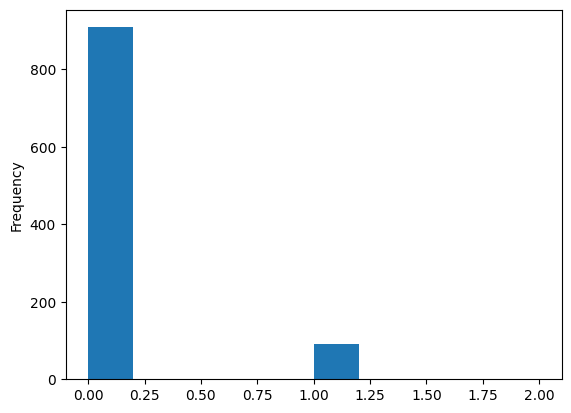

In [496]:
mapped_data['160003'].plot.hist()

In [458]:
np.maximum(adoptions['bev'][lad_lsoas[:1]].fillna(0).astype(int), 0)

,E01014370
0,11
1,11
2,11
3,12
4,11
...,...
995,11
996,12
997,11
998,11


In [499]:
ds_lad['Substation Number']

Substation Number
110055    110055
110060    110060
110066    110066
110165    110165
110182    110182
           ...  
183036    183036
183052    183052
183057    183057
183114    183114
183123    183123
Name: Substation Number, Length: 1760, dtype: object

In [501]:
len(ds_lad['Substation Number'].unique())

1759

In [489]:
child_ds, intersections = find_child_ds(lad_lsoas[:1])
child_ds

array(['160003', '160004', '160013', '160035', '160056', '160083',
       '160100', '160164', '160165', '160179', '160182', '160186',
       '160219', '160230', '160231', '160233', '160233', '160235',
       '160246', '160261', '160295', '160344', '160345', '160379',
       '160383', '160387', '160394', '164033', '164039', '164051',
       '164056', '164058', '164092', '164097', '164109', '164113',
       '164117', '164120', '164150', '164168', '164169', '164173',
       '164174', '164185', '164187', '164192', '164197', '164206',
       '164208'], dtype=object)

In [475]:
lad_lsoas[:1]

array(['E01014370'], dtype=object)

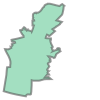

In [482]:
lad_preprocessed_data['lsoa_boundaries'].loc[lad_lsoas[:1]].iloc[0].geometry

In [484]:
intersections = ds_lad.geometry.intersection(lad_preprocessed_data['lsoa_boundaries'].loc[lad_lsoas[:1]].iloc[0].geometry)
intersections

Substation Number
110055    POLYGON EMPTY
110060    POLYGON EMPTY
110066    POLYGON EMPTY
110165    POLYGON EMPTY
110182    POLYGON EMPTY
              ...      
183036    POLYGON EMPTY
183052    POLYGON EMPTY
183057    POLYGON EMPTY
183114    POLYGON EMPTY
183123    POLYGON EMPTY
Length: 1760, dtype: geometry

In [485]:
pip_mask = ~intersections.is_empty
pip_mask

Substation Number
110055    False
110060    False
110066    False
110165    False
110182    False
          ...  
183036    False
183052    False
183057    False
183114    False
183123    False
Length: 1760, dtype: bool

In [486]:
intersections = ds_lad.geometry.intersection(lad_preprocessed_data['lsoa_boundaries'].loc[lad_lsoas[:1]].iloc[0].geometry)
pip_mask = ~intersections.is_empty
child_ds = ds_lad[pip_mask].index.values

In [490]:
child_ds, intersections = find_child_ds(lad_lsoas[:1])

intersection_areas = intersections.loc[child_ds].area
lsoa_area = lad_preprocessed_data['lsoa_boundaries'].loc[lsoa].geometry.area
substation_areas = ds_lad.loc[child_ds].geometry.area
relative_intersections = intersection_areas / substation_areas
ds_customers_in_lsoa = relative_intersections * ds_lad.loc[child_ds, 'Customers']
ds_customers_in_lsoa.fillna(0)

prop_customers = ds_customers_in_lsoa/ds_customers_in_lsoa.sum() # Proportion of DS customers in LSOA
prop_customers

Substation Number
160003    0.008916
160004    0.040884
160013    0.032588
160035    0.043383
160056    0.060047
160083    0.043093
160100    0.026999
160164    0.002853
160165    0.011329
160179    0.017476
160182    0.046233
160186    0.003107
160219    0.040133
160230    0.000156
160231    0.026012
160233    0.033200
160233    0.060058
160233    0.033200
160233    0.060058
160235    0.014186
160246    0.001607
160261    0.013878
160295    0.019504
160344    0.001966
160345    0.055512
160379         NaN
160383    0.002854
160387    0.027006
160394    0.026256
164033    0.004100
164039    0.065537
164051    0.003803
164056         NaN
164058         NaN
164092    0.019113
164097    0.021755
164109    0.036757
164113    0.017591
164117    0.011508
164120    0.000492
164150    0.009752
164168    0.005626
164169         NaN
164173    0.000124
164174    0.010790
164185    0.024050
164187         NaN
164192         NaN
164197    0.013141
164206         NaN
164208    0.003372
dtype: float6

In [469]:
len(child_ds)

1760

In [467]:
ds_lad.loc[child_ds, 'Customers']

Substation Number
110055    130.0
110060    113.0
110066     94.0
110165     47.0
110182     54.0
          ...  
183036      NaN
183052      NaN
183057      NaN
183114      NaN
183123      NaN
Name: Customers, Length: 1762, dtype: float64

In [464]:
ds_customers_in_lsoa.sum()

0.0

In [463]:
for ds in child_ds:
    p = np.clip(prop_customers.loc[ds], 0, 1)
    print(p)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
